# LLM - Detect AI Generated Text
# (NN) Dense connected Neural Network

## Import

In [1]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve ,precision_recall_curve,auc,confusion_matrix,ConfusionMatrixDisplay
import keras

2024-01-26 21:20:57.665588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 21:20:57.665651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 21:20:57.697743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 21:20:57.744607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 21:20:59.086580: W tensorflow/compiler/tf2

In [2]:
train_dataset=pd.read_csv("../data/lexp/pre_processed/train.csv")
train_dataset

,id,prompt_id,generated,0,1,2,3,4,5,6,...,96,97,98,99,100,101,102,103,104,105
0,41165,0,1,0.004023,0.003139,0.004303,0.000000,0.0,0.024149,-0.012406,...,-0.059754,-0.013995,-0.003609,-0.054222,0.005852,-0.162204,0.129035,-0.113359,0.072855,0.250193
1,56704,13,1,0.007118,0.005992,0.007358,0.003764,0.0,0.009624,0.016637,...,0.148504,0.179979,0.162245,-0.031815,0.126953,0.080496,0.139554,0.151027,0.093111,0.304024
2,49646,13,1,0.005426,0.007704,0.007080,0.000000,0.0,0.098738,0.126639,...,0.041842,-0.041917,-0.060383,-0.060455,0.021589,-0.032543,-0.070403,0.043904,-0.039627,0.309329
3,65909,11,1,0.004890,0.005136,0.004720,0.000000,0.0,-0.047298,-0.145219,...,-0.061865,0.113064,0.122951,-0.119200,0.019564,-0.112948,-0.080771,0.027291,0.060934,0.226686
4,36693,13,1,0.005323,0.005706,0.005692,0.000000,0.0,-0.053892,0.051193,...,0.049328,0.019387,-0.052216,0.033253,0.078349,-0.076047,-0.020799,-0.052328,0.183286,0.381400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29433,34559,15,1,0.004993,0.005706,0.005275,0.045164,0.0,0.009123,-0.063777,...,0.123257,-0.081951,0.022218,0.047455,-0.058179,0.022473,0.102880,0.049880,-0.006577,0.417857
29434,59384,11,1,0.005220,0.005136,0.005553,0.000000,0.0,-0.078960,-0.006486,...,-0.061180,0.120647,0.001908,0.035093,0.091502,0.048425,0.008579,-0.069383,0.006188,0.241051
29435,39318,15,1,0.004065,0.003709,0.003748,0.015055,0.0,0.023342,0.130713,...,0.033398,0.052869,0.122322,0.186538,-0.063021,0.013305,0.097663,-0.175404,0.084010,0.386586
29436,16869,11,0,0.007778,0.013410,0.009162,0.000000,0.0,0.052244,-0.040034,...,0.164946,-0.119586,0.091539,-0.003745,-0.027525,0.014295,-0.186965,0.019864,-0.132460,0.429293


In [68]:
train_dataset.describe()

,prompt_id,generated,0,1,2,3,4,5,6,7,...,96,97,98,99,100,101,102,103,104,105
count,29438.000000,29438.000000,29438.000000,29438.000000,29438.000000,29438.000000,29438.0,29438.000000,29438.000000,29438.000000,...,29438.000000,29438.000000,29438.000000,29438.000000,29438.000000,29438.000000,29438.000000,29438.000000,29438.000000,29438.000000
mean,10.102215,0.624907,0.005294,0.005343,0.005230,0.001844,0.0,-0.028822,0.007966,-0.031138,...,0.018810,0.030656,0.025275,0.042946,0.029790,-0.011036,-0.019435,-0.006982,0.036584,0.308935
std,5.949863,0.484155,0.002437,0.002328,0.002572,0.005529,0.0,0.089582,0.080259,0.092490,...,0.088242,0.085166,0.087111,0.085361,0.090898,0.087654,0.079772,0.092316,0.089069,0.097313
min,0.000000,0.000000,0.000330,0.000000,0.000000,0.000000,0.0,-0.393019,-0.309899,-0.402779,...,-0.291346,-0.349729,-0.325731,-0.292291,-0.299977,-0.358315,-0.401856,-0.344275,-0.336993,0.000000
25%,8.000000,0.000000,0.003673,0.003709,0.003471,0.000000,0.0,-0.089550,-0.044683,-0.096680,...,-0.042299,-0.025866,-0.033011,-0.014693,-0.031839,-0.069993,-0.073132,-0.070922,-0.023829,0.241928
50%,11.000000,1.000000,0.004890,0.005136,0.004859,0.000000,0.0,-0.029808,0.008844,-0.035751,...,0.017236,0.033933,0.027265,0.042208,0.031355,-0.011381,-0.018713,-0.009780,0.036109,0.296788
75%,14.000000,1.000000,0.006314,0.006562,0.006663,0.000000,0.0,0.031028,0.061857,0.031251,...,0.078834,0.090246,0.085935,0.100554,0.092498,0.048534,0.035265,0.053152,0.097720,0.365968
max,20.000000,1.000000,0.022881,0.025394,0.021517,0.180656,0.0,0.348934,0.327177,0.309563,...,0.357897,0.317854,0.333982,0.401939,0.379826,0.323404,0.292709,0.391041,0.368178,1.000000


## Random Downsampling

In [3]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]


    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")


    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

## ROC AUC curve

In [4]:
def ROCcurves(model,x_val,y_val):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    y_pred = model.predict(x_val).ravel()
    fpr, tpr , _ = roc_curve(y_val,  y_pred)
    auc_ss = auc(fpr,tpr)
    precision, recall, _ = precision_recall_curve(y_val,  y_pred)
    auc_pr = auc(recall, precision)

    # Primer subgráfico
    axs[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    axs[0].plot(fpr,tpr, label='ROC curve', color='blue')
    axs[0].set_title(f'ROC curve = {round(auc_ss,3)}')
    axs[0].set_xlabel('FalsePositiveRate')
    axs[0].set_ylabel('TruePositiveRate')
    axs[0].legend()
    # Segundo subgráfico
    axs[1].plot([0, 1], [0,0], color='gray', lw=1, linestyle='--', label='AUC = 0.0')
    axs[1].plot(recall, precision, label='ROC-RP curve', color='orange')
    axs[1].set_title(f'ROC-RP curve = {round(auc_pr,3)}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()
    plt.show()



## Arquitecture

#kernel_regularizer=keras.regularizers.L1L2(l1=0.0, l2=0)
#x = keras.layers.Dropout(0.4)(x)

In [61]:
input = keras.Input(shape=(train_dataset.shape[1]-2,))
x = keras.layers.Dense(train_dataset.shape[1]-2,activation="relu")(input)
x = keras.layers.Dense(1000,activation="relu")(x)
output = keras.layers.Dense(1,activation="sigmoid")(x)

model = keras.Model(input,output)

model.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])

## Training

In [62]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = train_dataset.drop(["id","generated"],axis=1)
Y = train_dataset["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")

    model.fit(X_train_dwns,
                y_train_dwns,
                validation_data=(X_val,y_val),
                batch_size=100,
                epochs=1)

DOWNSAMPLED:(9938:9938)
199/199 [==============================] - 1s 4ms/step - loss: 0.2732 - auc_7: 0.9538 - val_loss: 0.1881 - val_auc_7: 0.9780
DOWNSAMPLED:(9938:9938)
199/199 [==============================] - 1s 4ms/step - loss: 0.1647 - auc_7: 0.9801 - val_loss: 0.1759 - val_auc_7: 0.9823
DOWNSAMPLED:(9938:9938)
199/199 [==============================] - 1s 4ms/step - loss: 0.1531 - auc_7: 0.9827 - val_loss: 0.1423 - val_auc_7: 0.9860
DOWNSAMPLED:(9938:9938)
199/199 [==============================] - 1s 4ms/step - loss: 0.1406 - auc_7: 0.9854 - val_loss: 0.1170 - val_auc_7: 0.9911
DOWNSAMPLED:(9938:9938)
199/199 [==============================] - 1s 4ms/step - loss: 0.1287 - auc_7: 0.9881 - val_loss: 0.1448 - val_auc_7: 0.9893
DOWNSAMPLED:(9938:9938)
199/199 [==============================] - 1s 4ms/step - loss: 0.1197 - auc_7: 0.9897 - val_loss: 0.1148 - val_auc_7: 0.9911
DOWNSAMPLED:(9937:9937)
199/199 [==============================] - 1s 4ms/step - loss: 0.1082 - auc_7: 0.9

920/920 [==============================] - 1s 1ms/step


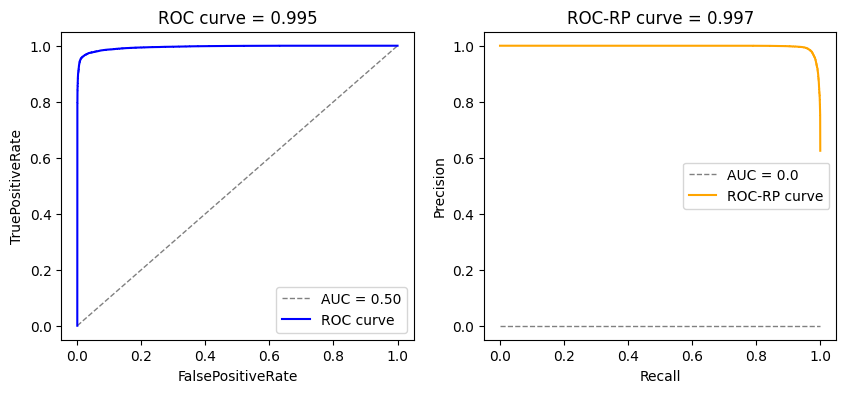

In [63]:
ROCcurves(model,X,Y)

920/920 [==============================] - 1s 1ms/step


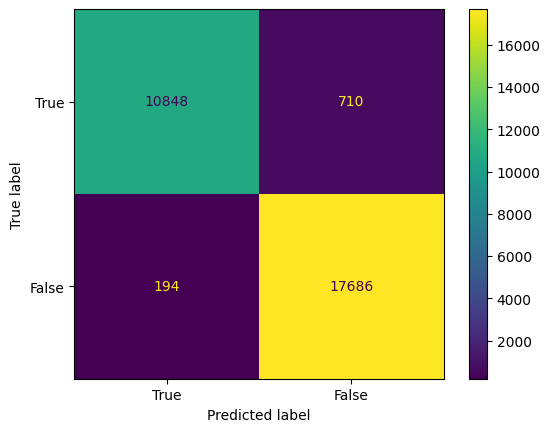

In [64]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,model.predict(x=X)))
display = ConfusionMatrixDisplay(confusion_matrix(pred,Y),display_labels=["True","False"])
display.plot()

In [65]:
model.predict(x=pd.DataFrame(X.iloc[1385]).transpose())

1/1 [==============================] - 0s 23ms/step


array([[0.01705193]], dtype=float32)

# Test model

1380/1380 [==============================] - 2s 1ms/step


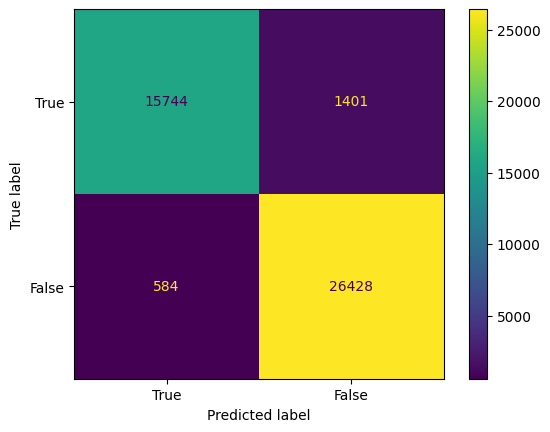

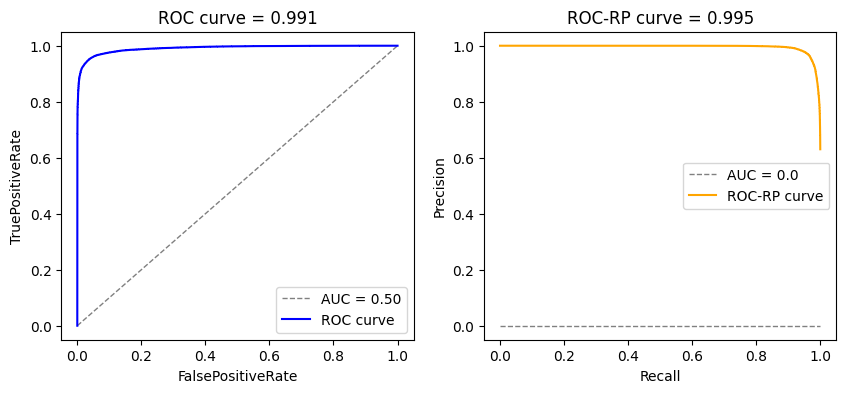

In [66]:

test_dataset = pd.read_csv("../data/lexp/pre_processed/test.csv")
X_test = test_dataset.drop(["id","generated"],axis=1)
Y_test = test_dataset[["generated"]]
pred = model.predict(x=X_test)
pred = [1 if p>=0.5 else 0 for p in pred]
ConfusionMatrixDisplay(confusion_matrix(pred,Y_test),display_labels=["True","False"]).plot()
ROCcurves(model,X_test,Y_test)


## Save model weights
Overfitting 2: 1 layer with 1000, 13 epochs & 100 batch_size
Regularized: equal to O2, but with

In [67]:
#model.save("../data/lexp/weight(prueba 2).h5")